# VCF - Parametric low-pass filter

A low pass filter where the following parameters are independently controllable:

- Cutoff frequency
- Resonance

In [29]:
from numpy import *
from matplotlib.pyplot import *
from scipy import signal
import scipy.io.wavfile

%load_ext line_profiler
%load_ext fortranmagic

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The fortranmagic extension is already loaded. To reload it, use:
  %reload_ext fortranmagic


In [2]:
class Simulator(object):
    def __init__(self, amplitude=2**15-1, yrange=[-50, 10]):
        self.amplitude = amplitude
        self.yrange = yrange
        
        self.fig, self.ax1 = subplots(1, 1, figsize=[8, 4])
        
        # Load/generate data files
        self.sample_rate_Hz = 44100
        fs, x = scipy.io.wavfile.read("../app/sound/prbs20.wav")
        assert(fs == self.sample_rate_Hz)
        self.x_prbs20 = self.amplitude * x/(2**15)
        
        t = arange(len(self.x_prbs20)) / self.sample_rate_Hz
        self.x_chirp = self.amplitude * signal.chirp(t, f0=20, f1=20e3, t1=max(t), method="linear")
    
    def vcf(self, x, cutoff, resonance):
        # Example filter
        b, a = signal.cheby1(2, 10, 1000 * 2/self.sample_rate_Hz, btype="low")
        return signal.lfilter(b, a, x)
    
    def simulate_chirp(self, cutoff, resonance):
        y = self.vcf(self.x_chirp, cutoff, resonance)
        
        f = linspace(20, 20e3, len(y))
        #H = 1/self.amplitude * y
        H = 1/self.amplitude * signal.hilbert(y)

        label = "cutoff={:.0f}, resonance={:.0f}".format(cutoff, resonance)
        self.plot_frequency_response(f, H, label=label)
        return 
    
    def simulate_prbs(self, cutoff, resonance, h_length=None):
        x = self.x_prbs20
        y = self.vcf(x, cutoff, resonance)
        
        if h_length is None:
            h_length = int(30/cutoff)

        t, h, f, H = self.analyze_prbs(x, y, h_length)
        label = "cutoff={:.0f}, resonance={:.0f}".format(cutoff, resonance)
        self.plot_frequency_response(f, H, label=label)
    
    def analyze_prbs(self, x, y, h_length):
        # Estimate impulse response using a pseudo-random bit sequence.
        h = signal.correlate(y, x, "full")
        h = h[len(h)//2:]

        # Limit the impulse response length to lower the noise
        h = h[0:h_length]
        t = arange(h_length)/self.sample_rate_Hz

        # Estimate frequency response
        H = fft.fft(h)
        H = H[0:len(H)//2] 
        H /= max(abs(H))
        f = linspace(0.01, self.sample_rate_Hz/2, len(H))

        return t, h, f, H

    def plot_frequency_response(self, f, H, label=None):
        self.ax1.semilogx(f, 20*ma.log10(abs(H)), label=label)

    def show(self):
        # Frequency response graph
        self.ax1.grid(True, "both", "both")
        self.ax1.legend()
        self.ax1.set_xlim(20, 20e3)
        self.ax1.set_ylim(*self.yrange)
        
        self.fig.tight_layout()
        #self.fig.show()


## Stilson and Smith 1996 Analyzing the Moog VCF with Considerations for Digital Implementation

Non-saturating filter with decoupled cutoff and resonance. Note that high resonances are not dampened and may cause overflow.

- Referred to in Valimaki 2006 Oscillator and Filter Algorithms for Virtual Analog Synthesis page 26.
- Here, a block diagram of the compromise onepole is shown.

In [110]:
class StilsonSmithCompromise(Simulator):
    def map_cutoff(self, value):
        assert(0 <= value <= 127)
        b = 0.02
        a = (0.8-b) / (127*127)
        return a*value*value + b

    def map_resonance(self, value):
        assert(0 <= value <= 127)
        b = 0.5
        a = (3.9-b) / 127
        return a*value + b
    
    def onepole(self, x, g, x1, y1):
        # Input -> summation point
        v = 1/1.3 * x + 0.3/1.3*x1
        
        # Summation point -> output
        y = (v-y1)*g + y1
        
        # Delay lines
        return y

    def vcf(self, x, cutoff, resonance):
        y = zeros(len(x))
        g = self.map_cutoff(cutoff)
        k = self.map_resonance(resonance)

        # Onepole delay points:
        # - Before op1
        # - After opN for N in 1...4
        w = [0, 0, 0, 0, 0] # Current sample
        d = [0, 0, 0, 0, 0] # Delayed sample

        for n in range(1, len(y)):
            w[0] = x[n] - d[4]*k
            w[1] = self.onepole(w[0], g, d[0], d[1])
            w[2] = self.onepole(w[1], g, d[1], d[2])
            w[3] = self.onepole(w[2], g, d[2], d[3])
            w[4] = self.onepole(w[3], g, d[3], d[4])
            
            for i in range(5):
                d[i] = w[i]
            
            y[n] = w[4]
            
        return y

## Optimizing speed of Stilson-Smith with Fortran

- http://arogozhnikov.github.io/2015/11/29/using-fortran-from-python.html

In [109]:
def vcf(self, x, cutoff, resonance):
        y = zeros(len(x))
        g = self.map_cutoff(cutoff)
        k = self.map_resonance(resonance)

        # Onepole delay points:
        # - Before op1
        # - After opN for N in 1...4
        w = [0, 0, 0, 0, 0] # Current sample
        d = [0, 0, 0, 0, 0] # Delayed sample

        for n in range(1, len(y)):
            
            w[0] = x[n] - d[4]*k
            w[1] = self.onepole(w[0], g, d[0], d[1])
            w[2] = self.onepole(w[1], g, d[1], d[2])
            w[3] = self.onepole(w[2], g, d[2], d[3])
            w[4] = self.onepole(w[3], g, d[3], d[4])
            
            for i in range(5):
                d[i] = w[i]
            
            y[n] = w[4]
            
        return y

In [209]:
%%fortran -v

real function stilson_smith_onepole(x, g, x1, y1)
    implicit none
    real, intent(in) :: x, g, x1, y1
    real :: v

    v = 1/1.3 * x + 0.3/1.3*x1
    stilson_smith_onepole = (v-y1)*g + y1
end function

subroutine stilson_smith_vcf(x, g, k, y)
    real, intent(in) :: x(:), g, k
    real, intent(out) :: y(size(x))
    real :: w(5), d(5)
    integer :: n
            
    w(:) = (/0, 0, 0, 0, 0/)
    d(:) = (/0, 0, 0, 0, 0/)
    
    do n = 1, size(x)
        w(1) = x(n) - d(5)*k
        w(2) = stilson_smith_onepole(w(1), g, d(1), d(2))
        w(3) = stilson_smith_onepole(w(2), g, d(2), d(3))
        w(4) = stilson_smith_onepole(w(3), g, d(3), d(4))
        w(5) = stilson_smith_onepole(w(4), g, d(4), d(5))
        
        d(:) = w(:)
        y(n) = w(5)
    end do
end subroutine


Ok. The following fortran objects are ready to use: stilson_smith_onepole, stilson_smith_vcf


In [212]:
class StilsonSmithCompromiseFast(StilsonSmithCompromise):
    def onepole(self, x, g, x1, y1):
        y = stilson_smith_onepole(x, g, x1, y1)
        return y
    
    def vcf(self, x, cutoff, resonance):
        #y = super().vcf(x, cutoff, resonance)
        g = self.map_cutoff(cutoff)
        k = self.map_resonance(resonance)
        y = stilson_smith_vcf(x, g, k)
        return y

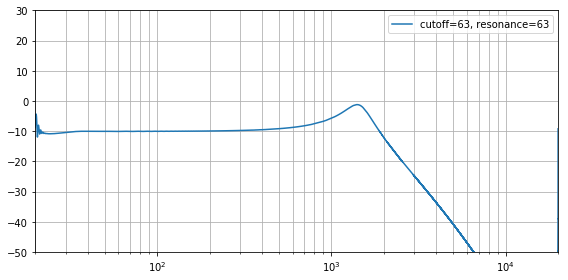

Timer unit: 1e-06 s

Total time: 0.055134 s
File: <ipython-input-212-e7c28eff7871>
Function: vcf at line 6

Line #      Hits         Time  Per Hit   % Time  Line Contents
     6                                               def vcf(self, x, cutoff, resonance):
     7                                                   #y = super().vcf(x, cutoff, resonance)
     8         1          7.0      7.0      0.0          g = self.map_cutoff(cutoff)
     9         1          3.0      3.0      0.0          k = self.map_resonance(resonance)
    10         1      55122.0  55122.0    100.0          y = stilson_smith_vcf(x, g, k)
    11         1          2.0      2.0      0.0          return y

In [213]:
s = StilsonSmithCompromiseFast(yrange=[-50, 30])
%lprun -f s.vcf s.simulate_chirp(63, 63)
s.show()

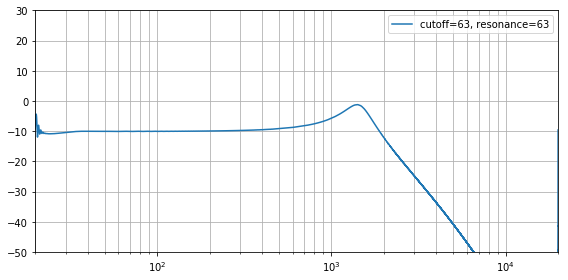

Timer unit: 1e-06 s

Total time: 16.2917 s
File: <ipython-input-110-ccfe9bf35bd0>
Function: vcf at line 24

Line #      Hits         Time  Per Hit   % Time  Line Contents
    24                                               def vcf(self, x, cutoff, resonance):
    25         1        487.0    487.0      0.0          y = zeros(len(x))
    26         1         10.0     10.0      0.0          g = self.map_cutoff(cutoff)
    27         1          4.0      4.0      0.0          k = self.map_resonance(resonance)
    28                                           
    29                                                   # Onepole delay points:
    30                                                   # - Before op1
    31                                                   # - After opN for N in 1...4
    32         1          0.0      0.0      0.0          w = [0, 0, 0, 0, 0] # Current sample
    33         1          1.0      1.0      0.0          d = [0, 0, 0, 0, 0] # Delayed sample
    34     

In [214]:
s = StilsonSmithCompromise(yrange=[-50, 30])
%lprun -f s.vcf s.simulate_chirp(63, 63)
s.show()

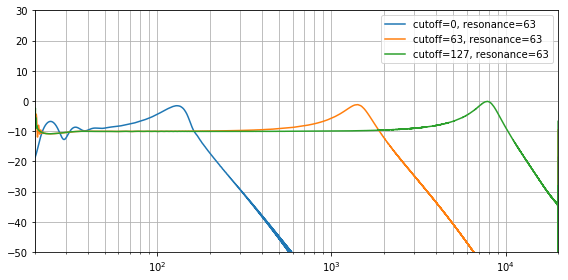

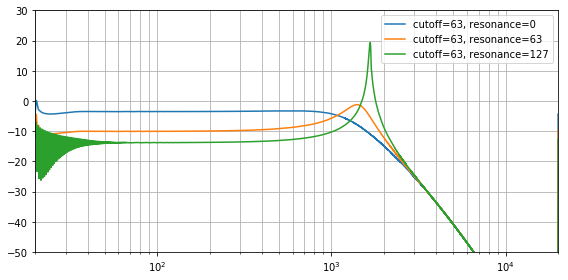

In [4]:
# Sweep cutoff
s = StilsonSmithCompromise(yrange=[-50, 30])
for cutoff in [0, 63, 127]:
    s.simulate_chirp(cutoff, 63)
s.show()

# Sweep resonance
s = StilsonSmithCompromise(yrange=[-50, 30])
for res in [0, 63, 127]:
    s.simulate_chirp(63, res)
s.show()

In [12]:
%load_ext fortranmagic

The fortranmagic extension is already loaded. To reload it, use:
  %reload_ext fortranmagic


In [15]:
%%fortran
subroutine vcf(x, y, cutoff, resonance)
    real, intent(in) :: x(:), cutoff, resonance
    real, intent(out) :: y(size(x))
    
    ! using vector operations
    y(:) = 0.5*x(:)
end subroutine

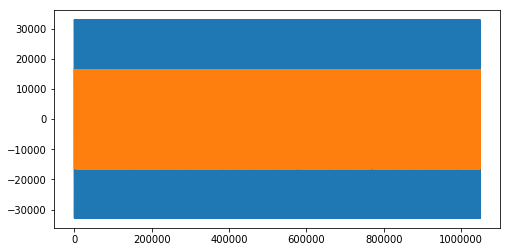

In [19]:
s = StilsonSmithCompromise()
x = s.x_chirp
y = vcf(x, 0, 0)
plot(x)
plot(y)

## Pirkle 2019 Designing Audio Effects Plugins in C++

Non-saturating but with a hard limiter on the output.

Addendum A11.

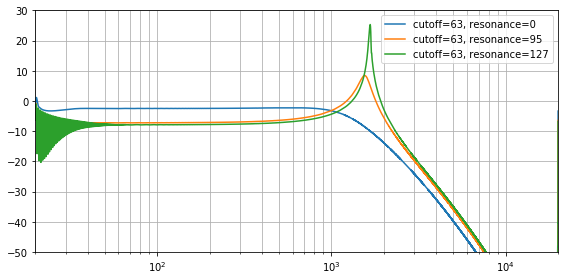

In [7]:
class Pirkle(StilsonSmithCompromise):
    def vcf(self, x, cutoff, resonance):
        y = zeros(len(x))
        g = self.map_cutoff(cutoff)
        k = self.map_resonance(resonance)
        G_comp = 0.25

        x1 = [0, 0, 0, 0] # Delayed onepole input
        y1 = [0, 0, 0, 0] # Delayed onepole output
        for n in range(1, len(y)):
            y_ = x[n]
            y_ = y_ - k * (y1[3] - G_comp*y_)
            
            y_, x1[0], y1[0] = self.onepole(y_, g, x1[0], y1[0])
            y_, x1[1], y1[1] = self.onepole(y_, g, x1[1], y1[1])
            y_, x1[2], y1[2] = self.onepole(y_, g, x1[2], y1[2])
            y_, x1[3], y1[3] = self.onepole(y_, g, x1[3], y1[3])
            y[n] = y_
            
        return y
    
# Sweep cutoff
#s = Pirkle(yrange=[-50, 30])
#for cutoff in [0, 63, 127]:
#    s.simulate_chirp(cutoff, 63)
#s.show()

# Sweep resonance
s = Pirkle(yrange=[-50, 30])
for resonance in [0, 95, 127]:
    s.simulate_chirp(63, resonance)
s.show()

## Peak limiter

Lyons 2011 Understanding digital signal processing Section 13.30.

/home/soren/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


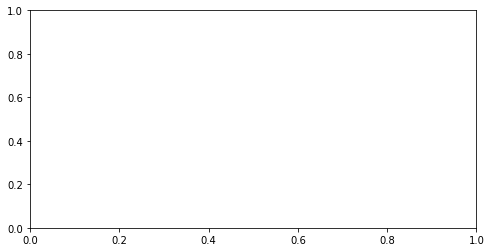

In [9]:
def limiter(x, R):
    a = 0.01
    y = zeros(len(x))
    
    w1 = 1 # Delayed feedback element
    
    for n in range(len(x)):  
        y[n] = x[n] * w1
        
        w = y[n]*y[n]
        w = R - w
        w = w + w1
        w1 = w
        
    return y
        
        
s = Pirkle(yrange=[-50, 30])
y = s.vcf(s.x_chirp, cutoff=63, resonance=100)
y2 = limiter(y, s.amplitude)
#plot(y)
#plot(limiter(y, s.amplitude))
#axhline(s.amplitude, color="k")
#axhline(-s.amplitude, color="k")